In [450]:
# import required modules
import numpy
import os
import random
import shutil
import json
from IPython.display import clear_output
from PIL import Image

In [451]:
# set directory paths
path_to_root = '../../..'
INPUT_DIR = os.path.join(path_to_root, 'data/imagery-6-7-2019_Cropped/test_set/images')
IMAGE_OUTPUT_DIR = os.path.join(path_to_root, 'data/imagery-6-7-2019_Cropped/test_set/cropped/images/')
LABEL_OUTPUT_DIR = os.path.join(path_to_root, 'data/imagery-6-7-2019_Cropped/test_set/cropped/labels/')
JSON_OUTPUT_DIR = os.path.join(path_to_root, 'data/imagery-6-7-2019_Cropped/test_set/cropped/json/')

In [452]:
# obtain dam files
print('input directory:', INPUT_DIR)
dam_imgs = os.listdir(INPUT_DIR)
print('\nimages:')
for filename in dam_imgs[:20]:
    print(filename)
print('\nlength:', len(dam_imgs))

input directory: ../../../data/imagery-6-7-2019_Cropped/test_set/images

images:
100711_clipped.png
83496_clipped.png
2166_clipped.png
46268_clipped.png
28262_clipped.png
19536_clipped.png
15200_clipped.png
114995_clipped.png
405-1330_not_a_dam.png
117189_clipped.png
100613_clipped.png
105419_clipped.png
105134_clipped.png
1279-1230_not_a_dam.png
5518_clipped.png
117174_clipped.png
2506_clipped.png
119616_clipped.png
121747_clipped.png
112469_clipped.png

length: 7232


In [453]:
# new size dimensions
cropped_size = 300

ratio = 419 / cropped_size
size_diff = 419 - cropped_size + 1 

In [454]:
# loop for crop & offset
for i in range(len(dam_imgs)):
    
    # print iteration
    clear_output(wait = True)
    print('Progress:', i + 1, '/', len(dam_imgs))
    print(dam_imgs[i])
    
    # open image of dam
    dam_filepath = os.path.join(INPUT_DIR, dam_imgs[i])
    dam = Image.open(dam_filepath)
    
    # crop to input dimensions and offset
    offset = random.randint(-(size_diff / 2), size_diff / 2)
    min_val = size_diff / 2 + offset
    max_val = 419 - size_diff / 2 + offset
    region = (min_val, min_val, max_val, max_val)
    cropped_dam = dam.crop(region)
    print('offset:', offset)
   
    # save as png
    clipped_filename = dam_imgs[i]
    if 'clipped' in clipped_filename:
        cropped_filename = clipped_filename.replace('clipped', 'cropped')
    else:
        cropped_filename = clipped_filename
    cropped_dam.save(os.path.join(IMAGE_OUTPUT_DIR, cropped_filename))
    
    # open label_input file and create label_output file
    clipped_filepath = os.path.join(INPUT_DIR, dam_imgs[i])
    label_filepath_src = clipped_filepath.replace('images', 'labels').replace('png', 'txt')
    label_filepath_dst = os.path.join(LABEL_OUTPUT_DIR, cropped_filename.replace('png', 'txt'))
    shutil.copyfile(label_filepath_src, label_filepath_dst)
    json_filepath = os.path.join(JSON_OUTPUT_DIR, clipped_filename.replace('clipped', 'cropped').replace('.png', '.json'))
    
    # parse label_input and write label_output (for darknet-style inputs)
    if 'not_a_dam' in label_filepath_src:
        label_str = ''
        with open(label_filepath_dst, 'w') as label_output:
            label_output.write(label_str)
    else:
        with open(label_filepath_src, 'r') as label_input:
            data = label_input.readline()
            if len(data) > 0:
                input_norm_x = float(data[2:10])
                input_norm_y = float(data[11:19])
                input_norm_w = float(data[20:28])
                input_norm_h = float(data[29:])
                output_norm_x = (input_norm_x * cropped_size - offset) / cropped_size
                output_norm_y = (input_norm_y * cropped_size - offset) / cropped_size
                output_norm_w = ratio * input_norm_w
                output_norm_h = ratio * input_norm_h
        with open(label_filepath_dst, 'w') as label_output:
            output_str = '0 ' + str('%.6f'%output_norm_x) + ' ' + str('%.6f'%output_norm_y) + ' ' + str('%.6f'%output_norm_w) + ' ' + str('%.6f'%output_norm_h)
            label_output.write(output_str)
    
    # create json files (for tfod inputs)
    if 'not_a_dam' in label_filepath_src:
        image_metadata = {}
        with open(json_filepath, 'w') as json_file:
            json.dump(image_metadata, json_file)
    else:
        image_metadata = {'pixel_bounding_box' : [            
            int(cropped_size * (output_norm_x - output_norm_w / 2)), 
            int(cropped_size * (output_norm_y - output_norm_h / 2)), 
            int(cropped_size * (output_norm_x + output_norm_w / 2)),
            int(cropped_size * (output_norm_y + output_norm_h / 2))
        ]}
        with open(json_filepath, 'w') as json_file:
            json.dump(image_metadata, json_file)


Progress: 7232 / 7232
111358_clipped.png


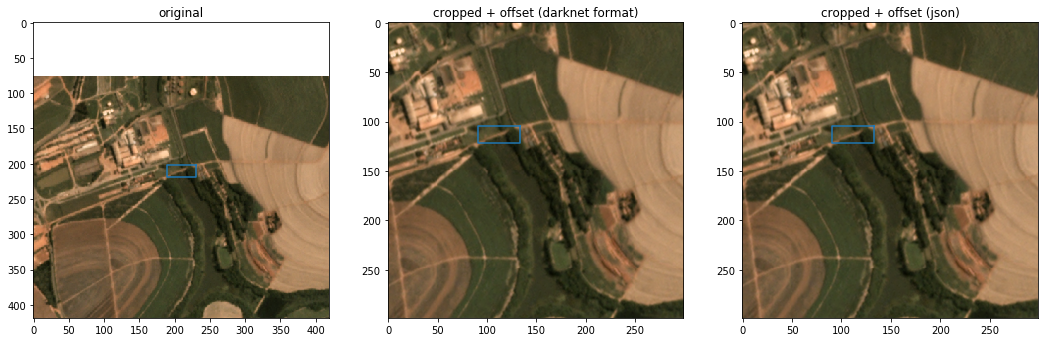

In [449]:
# visualize with matplotlib (for debug purposes)

# import required libaries
from shapely import geometry
from matplotlib import image as mpimg
from matplotlib import pyplot as plt

# read inputs
x = random.randint(0, len(dam_imgs))
dam = mpimg.imread(os.path.join(INPUT_DIR, dam_imgs[x]))
crop = mpimg.imread(os.path.join(IMAGE_OUTPUT_DIR, dam_imgs[x].replace('clipped', 'cropped')))

# original label
label_original = os.path.join(INPUT_DIR, dam_imgs[x]).replace('images', 'labels').replace('.png', '.txt')
label_filename = dam_imgs[x].replace('images', 'labels').replace('.png', '.txt')
with open(label_original, 'r') as label_original_txt:
    data = label_original_txt.readline()
    norm_x = float(data[2:10])
    norm_y = float(data[11:19])
    norm_w = float(data[20:28])
    norm_h = float(data[29:])
    x = int(norm_x * 419)
    y = int(norm_y * 419)
    w = int(norm_w * 419)
    h = int(norm_h * 419)

# create polygon for bounding box 1
bbox1 = shapely.geometry.box(210 - w / 2, 210 - h / 2, 210 + w / 2, 210 + h / 2)
x1,y1 = bbox1.exterior.xy

# cropped label
with open(os.path.join(LABEL_OUTPUT_DIR, label_filename.replace('clipped', 'cropped')), 'r') as label_cropped:
    data = label_cropped.readline()
    norm_x = float(data[2:10])
    norm_y = float(data[11:19])
    norm_w = float(data[20:28])
    norm_h = float(data[29:])
    x = int(norm_x * cropped_size)
    y = int(norm_y * cropped_size)
    w = int(norm_w * cropped_size)
    h = int(norm_h * cropped_size)

# create polygon for bounding box 2
bbox2 = shapely.geometry.box(x - w / 2, y - h / 2, x + w / 2, y + h / 2)
x2,y2 = bbox2.exterior.xy

# cropped json file
json_filename = label_filename.replace('clipped', 'cropped').replace('.txt', '.json')
with open(os.path.join(JSON_OUTPUT_DIR, json_filename), 'r') as json_cropped:
    image_metadata = json.load(json_cropped)
    coords = image_metadata['pixel_bounding_box']
    
# create polygon for bounding box 3
bbox3 = shapely.geometry.box(coords[0], coords[1], coords[2], coords[3])
x3,y3 = bbox3.exterior.xy
    
# visualize
fig = plt.figure(figsize=(18,18))
ax1 = fig.add_subplot(1,3,1)
ax1.set_title('original')
ax1.imshow(dam)
ax1.plot(x1,y1)
ax2 = fig.add_subplot(1,3,2)
ax2.set_title('cropped + offset (darknet format)')
ax2.imshow(crop)
ax2.plot(x2,y2)
ax3 = fig.add_subplot(1,3,3)
ax3.set_title('cropped + offset (json)')
ax3.imshow(crop)
ax3.plot(x3,y3)
plt.show()